## PNAS Cover Art simulations

Several fun visualizations that were submitted (but ultimately selected) for the cover art for PNAS.

In [2]:
from model import *
import networkx as nx
import numpy as np
from mayavi import mlab

In [3]:
def initIndividual (N, graph_type, p, d, edge_type):
    '''
    Function for building binary network structures:
    Gilbert Random, Erdos-Renyi Random, Barabasi-Albert Scale-Free
        
    Refer to simPopulation() for parameter definitions.
    '''
    # Initialize adjacency matrix
    if (graph_type == "Grandom_s") or (graph_type == "Grandom_d"):
        A = makeGilbertRandom (N, graph_type, p)
        
    elif (graph_type == "ERrandom_s") or (graph_type == "ERrandom_d"):
        A = makeERRandom (N, graph_type, p)
        
    elif (graph_type == "scale_free_s") or (graph_type == "scale_free_d"):
        A = makeBAScaleFree (N, graph_type, p)
    
    elif graph_type == "lattice":
        A = makeLattice (N, graph_type, p)
    
    elif graph_type == "none":
        A = np.ones((N,N))
        
    elif graph_type == 'sphere':
        A, positions = makeSphere(N)
    
    else:
        raise Exception ('Specified graph_type (' + graph_type + ') is not valid!')
    
    # Randomly weighted edges:
    if edge_type == 'binary':
        pass
    elif edge_type == 'random':
        A = randomWeights (A)
    else:
        raise Exception ("Specified edge_type is not valid!")
    
    # Initialize state vector (module/node vector)
    v = np.zeros(N)
    
    i = 0
    while i < N:
        rand_draw = random.uniform(0,1)
        if rand_draw < d:
            v[i] = 0 # failed
        else:
            v[i] = 1
        i += 1
    if graph_type != 'sphere':
        return (A, v)
    else:
        return (A, v, positions)


def makeLattice (N, graph_type, p):
    from networkx import grid_graph
    q = round(N/3) # number of edges for each dim
    G=grid_graph(dim=[q, q, q])
    G=nx.barabasi_albert_graph(N, q)
    A = nx.to_numpy_matrix(G)
    return (A)

In [10]:
check_start=0
check_end=100
N=125
p=0.05
d=0
f=0.025
r=0.01
f_thresh=0.8
graph_type='scale_free_s' # lattice, 
weight_type='uniform'
check_type='none'
kinetic=1
P_check=0.01
e=0
cost_type=['basic']
costC=0
costR=0
costE=0
costD=0
costL=0
P_repl=0
costrepl=0
max_repl=1
repl_type='constant'
node_type='binary'
damage_type='uniform'
edge_type='binary'
f_edge=0
r_edge=0
std=0.3
P_ablate=0
costablate=0
ablate_type='constant'
repair_start=0
repair_end='none'
delay=0
time_end='none'
dependency=0.5
save='no'
plot='yes'
write_inds='no'
preNet_list=False
equilibrate_failures=True
    
# Initialize individual adjacency matrix (A), state vector (v)
A, v = initIndividual (N, graph_type, p, d, edge_type)

# Initialize vector for number of nodes that the given is dependent on
num_neigh = np.sum(A,axis=0)

# Initialize replication counter vector
repl_v = np.zeros(N)

# Summary Lists
vitality = []
interdependence = []
costs = []

i = 0
while i >= 0: # runs until all nodes broken

    # Gets weight and degree vectors
    degree_vec = getDegrees (A)
    weight_vec = getWeights (weight_type, A, v, degree_vec)

    vitality_i, interdependence_i = Analyze(v, f, r, i, weight_vec)
    vitality.append(vitality_i)
    interdependence.append(interdependence_i)

    # Calculate incremental cost at time step
    if i > 0:
        cost = cost_cr + cost_repl + cost_ablate
        cost = getCosts(cost, costE, costD, costL, cost_r, cost_c, vitality_i, cost_type)
        costs.append(cost)
    else:
        costs.append(0)

    # Break if vitality lower than threshold
    if np.sum(v)/len(v) <= f_thresh or np.sum(v)==0: # stops when vitality passes threshold
        break

    # Stops data collection if time_end reaches
    if time_end != 'none' and i >= time_end:
        break
        
    # simulate stochastic damage
    A, v, f = Damage(A, v, f, damage_type, node_type, edge_type, f_edge, std, i)

    # Check and repair network
    if i >= repair_start:
        if repair_end != 'none':
            if i <= int(repair_end):
                cost_cr, A, v, P_check, r = Check_and_Repair(A, v, r, check_type, kinetic, P_check, e, i, costC, costR, 
                                                          node_type, edge_type, r_edge, std)
                cost_r = r
            else:
                cost_cr = 0
                cost_r = 0
        else:
            cost_cr, A, v, P_check, r = Check_and_Repair(A, v, r, check_type, kinetic, P_check, e, i, costC, costR, 
                                                          node_type, edge_type, r_edge, std)
            cost_r = r
    else:
        cost_cr = 0
        cost_r = 0

    # Checking delay costs
    if i >= check_start:
        if check_end != 'none':
            if i <= check_end:
                cost_c = P_check
            else:
                cost_c = 0
        else:
            cost_c = P_check
    else:
        cost_c = 0


    # Replicate
    if P_repl > 0:
        A, v, cost_repl, repl_v = Replicate (A, v, P_repl, costrepl, max_repl, repl_v, repl_type, i)
        costs.append(cost_repl)
    else:
        cost_repl = 0

    # Ablate
    if P_ablate > 0:
        A, v, cost_ablate = Ablate (A, v, P_ablate, costablate, ablate_type, i)
        costs.append(cost_ablate)
    else:
        cost_ablate = 0

    # dependency-related failure
    if dependency > 0:
        v = dependencyFail(A, v, num_neigh, dependency, equilibrate_failures)
        #v = dependencyFailOLD(A, v, dependency)

    i += 1

### Use NetworkX to visualize intermediately aged network

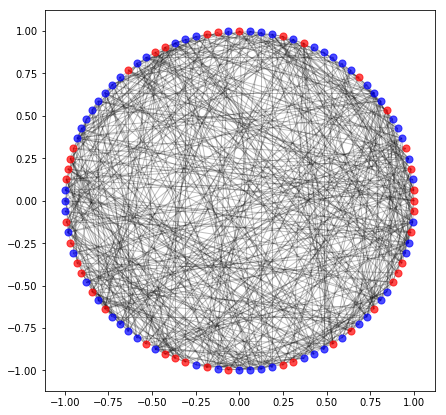

In [44]:
G = nx.from_numpy_matrix(A)
#v_dict = {str(i):v[i] for i in range(len(v))}
#nx.set_node_attributes(G,'status',v_dict)
live_nodes = [i for i in range(len(v)) if v[i]==1]
dead_nodes = [i for i in range(len(v)) if v[i]==0]

#pos = nx.spring_layout(G)
#pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)
#pos = nx.shell_layout(G,nlist=[list(np.arange(0,20)), list(np.arange(20,50)), list(np.arange(50,100))])
#pos = nx.random_layout(G)
#pos = nx.spiral_layout(G)
plt.figure(figsize=(7,7))
nx.draw_networkx_nodes(G,pos,nodelist=live_nodes,node_color='b',node_size=50,alpha=0.7)
nx.draw_networkx_nodes(G,pos,nodelist=dead_nodes,node_color='r',node_size=50,alpha=0.7)
nx.draw_networkx_edges(G,pos,nodelist=list(np.arange(len(v))),node_color='k',node_size=50,alpha=0.25)
plt.show()

# Mayavi

In [12]:
# needs mayavi2
# run with ipython -wthread
dead_nodes = [i for i in range(len(v)) if v[i]==0]

G = nx.from_numpy_matrix(A)


# reorder nodes from 0,len(G)-1
G=nx.convert_node_labels_to_integers(G)
# 3d spring layout
pos=nx.spring_layout(G,dim=3,iterations=1000)
# numpy array of x,y,z positions in sorted node order
xyz=np.array([pos[x] for x in sorted(G)])
red_xyz=np.array([pos[x] for i, x in enumerate(sorted(G)) if i in dead_nodes])
# scalar colors
scalars=np.abs(np.array(v)-1)

mlab.figure(1, bgcolor=(0, 0, 0))
mlab.clf()

pts = mlab.points3d(xyz[:,0], xyz[:,1], xyz[:,2],
                    scalars,
                    scale_factor=0.1,
                    scale_mode='none',
                    colormap='Reds',
                    resolution=20)

pts_border = mlab.points3d(red_xyz[:,0], red_xyz[:,1], red_xyz[:,2],
                    np.zeros(len(dead_nodes)),
                    scale_factor=0.25,
                    opacity=0.2,
                    scale_mode='none',
                    color=(0.8,0.1,0.1),
                    resolution=20)

rand_edges = np.array(G.edges())
np.random.shuffle(rand_edges)
sparse_edges = rand_edges[:round(len(rand_edges)*0.2),:]# sparsify edges

pts.mlab_source.dataset.lines = sparse_edges
tube = mlab.pipeline.tube(pts, tube_radius=0.0015)
mlab.pipeline.surface(tube, color=(0.8, 0.8, 0.8))

mlab.savefig('mayavi2_spring.png')
mlab.show()

## Spherical Network

In [5]:
def get_triangles(total_points):
    m = ((50-10*(5**(1/2)))**(1/2))/10
    n = ((50+10*(5**(1/2)))**(1/2))/10

    viewpoints = [[m, 0, n], [-m, 0, n], [m, 0, -n], [-m, 0, -n],
                  [0, n, m], [0, n, -m], [0, -n, m], [0, -n, -m],
                  [n, m, 0], [n, -m, 0], [-n, m, 0], [-n, -m, 0]]

    viewpoints = np.asarray(viewpoints)

    indices = []
    triangle_indices = set()

    for i in range(len(viewpoints)):
        for j in range(i+1, len(viewpoints)):
            #print(np.linalg.norm(viewpoints[i]-viewpoints[j]))
            if round(np.linalg.norm(viewpoints[i]-viewpoints[j]), 1) == 1.1:
                # print(i, j, np.linalg.norm(viewpoints[i]-viewpoints[j]))
                indices.append([i, j])

    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            set1 = set(indices[i])
            set2 = set(indices[j])
            if set1 & set2:    
                ssd = set1 ^ set2   
                if list(ssd) in indices:
                    #print(set1 | set2 | ssd)    
                    triangle_indices.add(tuple(sorted(list(set1 | set2 | ssd))))

    triangles = []    
    for t_i in triangle_indices:
        total_points.append(viewpoints[t_i[0]])
        total_points.append(viewpoints[t_i[1]])
        total_points.append(viewpoints[t_i[2]])
        # print(viewpoints[t_i[0]], viewpoints[t_i[1]], viewpoints[t_i[2]])
        triangles.append(viewpoints[np.array(t_i)])
    return (triangles, total_points)


def sample_points(data, total_data, total_points):
    for i in range(2):
        new_data = []
        for triangle in data:
            center_point1 = np.array((triangle[0]+triangle[1])/2)
            center_point2 = np.array((triangle[0]+triangle[2])/2)
            center_point3 = np.array((triangle[1]+triangle[2])/2)

            center_point1 = center_point1/np.linalg.norm(center_point1)
            center_point2 = center_point2 / np.linalg.norm(center_point2)
            center_point3 = center_point3 / np.linalg.norm(center_point3)
            total_points.append(center_point1)
            total_points.append(center_point2)
            total_points.append(center_point3)
            # total_points += list(triangle)

            new_data.append([triangle[0], center_point1, center_point2])
            new_data.append([triangle[1], center_point1, center_point3])
            new_data.append([triangle[2], center_point2, center_point3])
            new_data.append([center_point1, center_point2, center_point3])

        total_data += new_data
        data = new_data
        
    return (total_data, total_points)
        
def makeSphere (N, add_noise=True):
    total_data = []
    total_points = []
    threshold = 0.4 # for range(2)
    #threshold = 0.7 # for range(1)
    triangles, total_points = get_triangles(total_points)
    total_data, total_points = sample_points(triangles, total_data, total_points)
    print (len(total_points))
    # add some noise to sphere
    skip = 2
    plus = True
    for idx in range(len(total_points)):
        if idx % skip == 0 and plus is True:
            total_points[idx] = total_points[idx]*1.15
            plus = False
        elif idx % skip == 0 and plus is False:
            total_points[idx] = total_points[idx]*0.85
            plus = True
    selections = np.random.choice(np.arange(len(total_points)),N,replace=False)
    total_points = [t for i, t in enumerate(total_points) if i in selections]
    A = np.zeros((len(total_points),len(total_points)))
    for i in range(len(total_points)):
        for j in range(len(total_points)):
            distance = np.linalg.norm(total_points[i]-total_points[j])
            if distance <= threshold:
                A[i,j] = 1
            else:
                continue
    return (A, total_points)

In [9]:
check_start=0
check_end=100
N=360
p=0.05
d=0
f=0.025
r=0.01
f_thresh=0.9
graph_type='sphere' #sphere
weight_type='uniform'
check_type='none'
kinetic=1
P_check=0.01
e=0
cost_type=['basic']
costC=0
costR=0
costE=0
costD=0
costL=0
P_repl=0
costrepl=0
max_repl=1
repl_type='constant'
node_type='binary'
damage_type='uniform'
edge_type='binary'
f_edge=0
r_edge=0
std=0.3
P_ablate=0
costablate=0
ablate_type='constant'
repair_start=0
repair_end='none'
delay=0
time_end='none'
dependency=0.5
save='no'
plot='yes'
write_inds='no'
preNet_list=False
equilibrate_failures=True
    
# Initialize individual adjacency matrix (A), state vector (v)
A, v, positions = initIndividual (N, graph_type, p, d, edge_type)
    

# Initialize vector for number of nodes that the given is dependent on
num_neigh = np.sum(A,axis=0)

# Initialize replication counter vector
repl_v = np.zeros(N)

# Summary Lists
vitality = []
interdependence = []
costs = []

i = 0
while i >= 0: # runs until all nodes broken

    # Gets weight and degree vectors
    degree_vec = getDegrees (A)
    weight_vec = getWeights (weight_type, A, v, degree_vec)

    vitality_i, interdependence_i = Analyze(v, f, r, i, weight_vec)
    vitality.append(vitality_i)
    interdependence.append(interdependence_i)

    # Calculate incremental cost at time step
    if i > 0:
        cost = cost_cr + cost_repl + cost_ablate
        cost = getCosts(cost, costE, costD, costL, cost_r, cost_c, vitality_i, cost_type)
        costs.append(cost)
    else:
        costs.append(0)

    # Break if vitality lower than threshold
    if np.sum(v)/len(v) <= f_thresh or np.sum(v)==0: # stops when vitality passes threshold
        break

    # Stops data collection if time_end reaches
    if time_end != 'none' and i >= time_end:
        break
        
    # simulate stochastic damage
    A, v, f = Damage(A, v, f, damage_type, node_type, edge_type, f_edge, std, i)

    # Check and repair network
    if i >= repair_start:
        if repair_end != 'none':
            if i <= int(repair_end):
                cost_cr, A, v, P_check, r = Check_and_Repair(A, v, r, check_type, kinetic, P_check, e, i, costC, costR, 
                                                          node_type, edge_type, r_edge, std)
                cost_r = r
            else:
                cost_cr = 0
                cost_r = 0
        else:
            cost_cr, A, v, P_check, r = Check_and_Repair(A, v, r, check_type, kinetic, P_check, e, i, costC, costR, 
                                                          node_type, edge_type, r_edge, std)
            cost_r = r
    else:
        cost_cr = 0
        cost_r = 0

    # Checking delay costs
    if i >= check_start:
        if check_end != 'none':
            if i <= check_end:
                cost_c = P_check
            else:
                cost_c = 0
        else:
            cost_c = P_check
    else:
        cost_c = 0


    # Replicate
    if P_repl > 0:
        A, v, cost_repl, repl_v = Replicate (A, v, P_repl, costrepl, max_repl, repl_v, repl_type, i)
        costs.append(cost_repl)
    else:
        cost_repl = 0

    # Ablate
    if P_ablate > 0:
        A, v, cost_ablate = Ablate (A, v, P_ablate, costablate, ablate_type, i)
        costs.append(cost_ablate)
    else:
        cost_ablate = 0

    # dependency-related failure
    if dependency > 0:
        v = dependencyFail(A, v, num_neigh, dependency, equilibrate_failures)
        #v = dependencyFailOLD(A, v, dependency)

    i += 1

360


In [7]:
# needs mayavi2
# run with ipython -wthread
dead_nodes = [i for i in range(len(v)) if v[i]==0]

G = nx.from_numpy_matrix(A)

# reorder nodes from 0,len(G)-1
#G=nx.convert_node_labels_to_integers(G)
# 3d spring layout
pos=nx.spring_layout(G,dim=3,iterations=500)
for key in list(pos):
    pos[int(key)] = positions[int(key)]
# numpy array of x,y,z positions in sorted node order
xyz=np.array([pos[x] for x in sorted(G)])
red_xyz=np.array([pos[x] for i, x in enumerate(sorted(G)) if i in dead_nodes])
# scalar colors
scalars=np.abs(np.array(v)-1)

mlab.figure(1,bgcolor=(0.004,0.004,0.004))
mlab.clf()

pts = mlab.points3d(xyz[:,0], xyz[:,1], xyz[:,2],
                    scale_factor=0.075,
                    scale_mode='none',
                    color=(0.45,0.76,0.89),
                    resolution=500)

pts_red = mlab.points3d(red_xyz[:,0], red_xyz[:,1], red_xyz[:,2],
                    scale_factor=0.15,
                    scale_mode='none',
                    color=(0.70,0.28,0.27),
                    resolution=500)

#pts_border = mlab.points3d(red_xyz[:,0], red_xyz[:,1], red_xyz[:,2],
#                    np.zeros(len(dead_nodes)),
#                    scale_factor=0.15,
#                    opacity=0.25,
#                    scale_mode='none',
#                    color=(0.70,0.28,0.27),
#                    resolution=500)

rand_edges = np.array(G.edges())
np.random.shuffle(rand_edges)
sparse_edges = rand_edges[:round(len(rand_edges)*1.0),:]# sparsify edges

pts.mlab_source.dataset.lines = sparse_edges
tube = mlab.pipeline.tube(pts, tube_radius=0.0025)
mlab.pipeline.surface(tube, color=(0.8, 0.8, 0.8))

mlab.savefig('mayavi2_spring.png', magnification=10)
mlab.show()

In [21]:
# make transparent
from PIL import Image

img = Image.open('mayavi2_spring.png')
img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] == 1 and item[1] == 1 and item[2] == 1:
        newData.append((1, 1, 1, 0))
    else:
        newData.append(item)

img.putdata(newData)
img.save("mayavi2_spring.png", "PNG")